# Report

## Imports

In [1]:
import numpy as np
import cv2 as cv

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Preprocessing

In [2]:
# download the data
#! kaggle competitions download -c iapr24-coin-counter
#! unzip iapr24-coin-counter.zip && rm iapr24-coin-counter.zip

# clear the output for cleaner notebook
clear_output()

## Hough Transform

In [3]:
img_path = 'train/1. neutral_bg/L1010277.JPG'

ref_chf_path = 'ref/ref_chf.JPG'
ref_eur_path = 'ref/ref_eur.JPG'

In [4]:
def resize_image(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv.resize(image, dim, interpolation=cv.INTER_AREA)
    return resized

In [5]:
img = cv.imread(ref_chf_path, cv.IMREAD_GRAYSCALE)
img_resized = resize_image(img, 10)

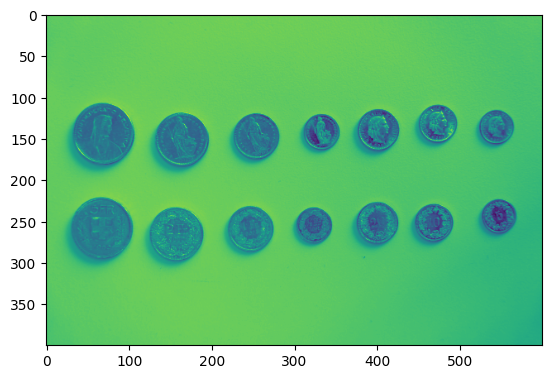

In [6]:
plt.imshow(img_resized)

In [7]:
img_blurred = cv.medianBlur(img_resized, 5)
cimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)

circles = cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50)

In [8]:
circles

array([[[ 68.5, 145.5,  37.3],
        [400.5, 252.5,  25.8],
        [162.5, 152.5,  33.5],
        [253.5, 147.5,  27.8],
        [ 66.5, 257.5,  36.2],
        [246.5, 260.5,  27.9],
        [401.5, 140.5,  25.8],
        [156.5, 264.5,  31.6],
        [545.5, 245.5,  22.4],
        [544.5, 139.5,  23.1],
        [323.5, 256.5,  21.8],
        [332.5, 143.5,  21.8],
        [473.5, 131.5,  22.3],
        [472.5, 251.5,  20.2]]], dtype=float32)

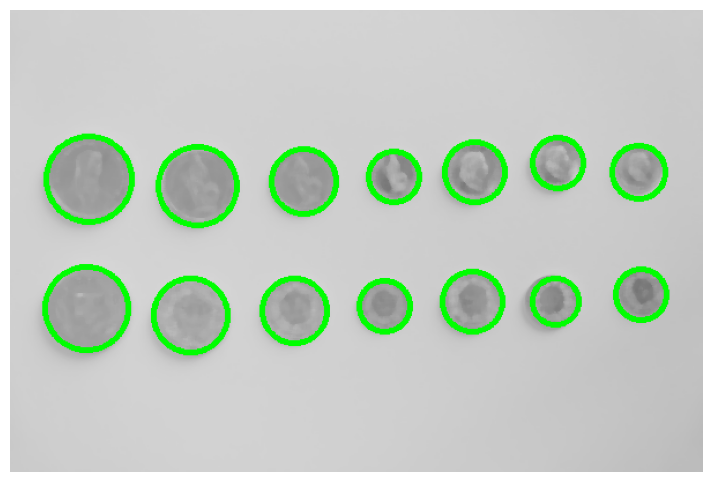

In [9]:
circles = np.uint16(np.around(circles))

for (x, y, r) in circles[0, :]:
        cv.circle(cimg, (x, y), r, (0, 255, 0), 4)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(cimg)
plt.axis('off')  # Hide the axis
plt.show()

In [10]:
# Ordering circles by radius
c = circles[0]
sorted_index = np.argsort(c[:, -1])
circles_sorted = c[sorted_index]

# finding max/min radii to provide better estimation in Hough transform
max_rad = np.max(circles_sorted[:, -1])
min_rad = np.min(circles_sorted[:, -1])
print(f"Max rad : {max_rad}\tMin rad : {min_rad}")


Max rad : 37	Min rad : 20


## Morphological functions

## Preprocessing & Hough transform tests

### Morphological functions

In [27]:
from skimage.morphology import disk, closing, opening

def apply_morphology(img_th, disk_radius, morphology):

    footprint = disk(disk_radius)
    return morphology(img_th, footprint)

def apply_closing(img_th, disk_radius):
    """
    Apply closing to input mask image using disk shape.

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.
    disk_size: int
        Size of the disk to use for closing

    Return
    ------
    img_closing: np.ndarray (M, N)
        Image after closing operation
    """
    footprint = disk(disk_radius)

    return closing(img_th, footprint)


def apply_opening(img_th, disk_radius):
    """
    Apply opening to input mask image using disk shape.

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.
    disk_size: int
        Size of the disk to use for opening

    Return
    ------
    img_opening: np.ndarray (M, N)
        Image after opening operation
    """
    footprint = disk(disk_radius)

    return opening(img_th, footprint)


### Closing

A single closing operation on a picture ran for more than 10 minutes...Unsustainable

In [12]:
# Taking list of problematic pictures
filenames = [f'L00000{i}.JPG' for i in range(60,71)]

test_path = 'test/'
hough_path = 'hough/'

# Iterating on each img
import os

# dict of functions
morphology_functions = {'c': apply_closing, 'o':apply_opening}

# Coin radius range in [15:45]
disk_size = 100

'''
for filename in filenames:
	filepath = os.path.join(test_path, filename)
	
	print(f"Begin with {filepath}")
	
	if os.path.isfile(filepath):
		
		
		# Open img and apply morphology
		img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)

		# Apply selected morphology
		img_resized = resize_image(img, 10)
		
		img_morph = apply_closing(img, disk_size)
		#img_morph = apply_morphology(img_resized, disk_size, morphology_functions['c'])
		cv.imwrite(os.path.join(os.path.join(hough_path, filename)), img_morph)
		
		img_blurred = cv.medianBlur(img_resized, 5)
		cimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)

		# Find circles with and without educated radii guess
		circles.append(cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50))
		c_prior = cv.HoughCircles(image=img_blurred, circles=cv.HOUGH_GRADIENT, method=1,  dp=20, minDist=min_rad, param1=70, param2=20, minRadius=min_rad, maxRadius=max_rad)
		circles_prior.append(c_prior)

		# Show circles on image and save
		c_prior_int = np.uint16(np.around(c_prior))

		for (x, y, r) in c_prior_int[0, :]:
			cv.imwrite(os.path.join(detect_dir_path, filename), cv.circle(cimg, (x, y), r, (0, 255, 0), 4))

		
		print(f"Done with {filename}")
		break
'''

'\nfor filename in filenames:\n\tfilepath = os.path.join(test_path, filename)\n\t\n\tprint(f"Begin with {filepath}")\n\t\n\tif os.path.isfile(filepath):\n\t\t\n\t\t\n\t\t# Open img and apply morphology\n\t\timg = cv.imread(filepath, cv.IMREAD_GRAYSCALE)\n\n\t\t# Apply selected morphology\n\t\timg_resized = resize_image(img, 10)\n\t\t\n\t\timg_morph = apply_closing(img, disk_size)\n\t\t#img_morph = apply_morphology(img_resized, disk_size, morphology_functions[\'c\'])\n\t\tcv.imwrite(os.path.join(os.path.join(hough_path, filename)), img_morph)\n\t\t\n\t\timg_blurred = cv.medianBlur(img_resized, 5)\n\t\tcimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)\n\n\t\t# Find circles with and without educated radii guess\n\t\tcircles.append(cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50))\n\t\tc_prior = cv.HoughCircles(image=img_blurred, circles=cv.HOUGH_GRADIENT, method=1,  dp=20, minDist=min_rad, param1=70, param2=20, minRadius=min_rad, ma

## Template matching
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_template.html#sphx-glr-auto-examples-features-detection-plot-template-py

In [ ]:
from skimage.feature import match_template

# Open template imgs
template_path = 'template'

### Single 2CHF coin on neutral background

In [24]:
# 2CHF template on Heads
template_filename = 'CHF_2_H.JPG'

# Test files
img_filenames = 'L0000001.JPG'

img = cv.imread(os.path.join(test_path, img_filenames), cv.IMREAD_GRAYSCALE)
template = cv.imread(os.path.join(template_path, template_filename), cv.IMREAD_GRAYSCALE)
#img_resized = resize_image(img, 10)

# Matching
result = match_template(img, template)

### Plot results

Coin is correctly found

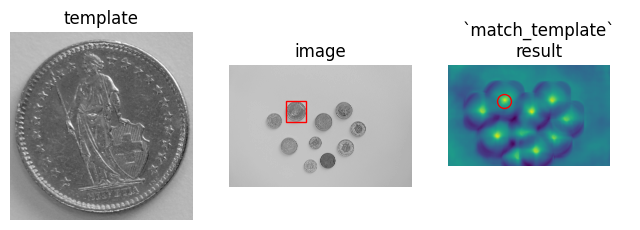

In [23]:
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(template, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(img, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = template.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

### Two 5CHF coins on a noisy background

Algorithm finds a coin where there is none, although there are 2 coins in the picture. Noise is clearly a limiting factor

In [25]:
# 5CHF tail template
template_filename = 'CHF_5_T.JPG'

# Test files
img_filenames = 'L0000002.JPG'


img = cv.imread(os.path.join(test_path, img_filenames), cv.IMREAD_GRAYSCALE)
template = cv.imread(os.path.join(template_path, template_filename), cv.IMREAD_GRAYSCALE)

# Matching
result = match_template(img, template)

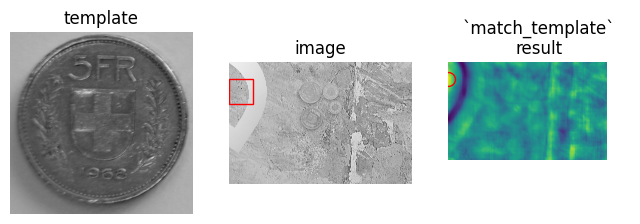

In [26]:
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(template, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('template')

ax2.imshow(img, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('image')
# highlight matched region
hcoin, wcoin = template.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

## Background denoising

### Thresholding background

Idea: find color space distribution of coins, threshold everything in img outside of this colorspace, so background is uniform and less prone to false positive

### Plotting functions from lab 1

In [32]:
from typing import Callable

# Plot color space distribution 
def plot_colors_histo(
    img: np.ndarray,
    func: Callable,
    labels: list[str],
):
    """
    Plot the original image (top) as well as the channel's color distributions (bottom).

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    func: Callable
        A callable function that extracts D channels from the input image
    labels: list of str
        List of D labels indicating the name of the channel
    """

    # Extract colors
    channels = func(img=img)
    C2 = len(channels)
    M, N, C1 = img.shape
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, C2)

    # Use random seed to downsample image colors (increase run speed - 10%)
    mask = np.random.RandomState(seed=0).rand(M, N) < 0.1
    
    # Plot base image
    ax = fig.add_subplot(gs[:2, :])
    ax.imshow(img)
    # Remove axis
    ax.axis('off')
    ax1 = fig.add_subplot(gs[2, 0])
    ax2 = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[2, 2])

    # Plot channel distributions
    ax1.scatter(channels[0][mask].flatten(), channels[1][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.set_title("{} vs {}".format(labels[0], labels[1]))
    ax2.scatter(channels[0][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax2.set_xlabel(labels[0])
    ax2.set_ylabel(labels[2])
    ax2.set_title("{} vs {}".format(labels[0], labels[2]))
    ax3.scatter(channels[1][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax3.set_xlabel(labels[1])
    ax3.set_ylabel(labels[2])
    ax3.set_title("{} vs {}".format(labels[1], labels[2]))
        
    plt.tight_layout()


NameError: name 'Callable' is not defined

In [33]:
def extract_rgb_channels(img):
    """
    Extract RGB channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_red: np.ndarray (M, N)
        Red channel of input image
    data_green: np.ndarray (M, N)
        Green channel of input image
    data_blue: np.ndarray (M, N)
        Blue channel of input image
    """
    data_red = np.copy(img[:, :, 0])
    data_green = np.copy(img[:, :, 1])
    data_blue = np.copy(img[:, :, 2])
    
    return data_red, data_green, data_blue

from skimage.color import rgb2hsv


def extract_hsv_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """
    img_hsv = rgb2hsv(np.copy(img))
    data_h = img_hsv[:, :, 0]
    data_s = img_hsv[:, :, 1]
    data_v = img_hsv[:, :, 2]
    
    return data_h, data_s, data_v

### Plotting coins

In [34]:
# 2CHF template on Heads
template_filename = 'CHF_2_H.JPG'

template = cv.imread(os.path.join(template_path, template_filename))

# Call plotting function with your implemented function
plot_colors_histo(
    img = template,
    func = extract_rgb_channels,
    labels = ["Red", "Green", "Blue"],
)

NameError: name 'plot_colors_histo' is not defined

## Finding radii distribution

In [14]:
# Iterating on each img
import os

min_rad = 15
max_rad = 42

circles = []
circles_prior = []

test_dir_path = 'test'
detect_dir_path = 'detect'

for filename in os.listdir(test_dir_path):
	filepath = os.path.join(test_dir_path, filename)
	
	if os.path.isfile(filepath):
		
		# Open img and resize
		img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
		img_resized = resize_image(img, 10)
		img_blurred = cv.medianBlur(img_resized, 5)
		cimg = cv.cvtColor(img_blurred, cv.COLOR_GRAY2BGR)

		# Find circles with and without educated radii guess
		circles.append(cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50))
		c_prior = cv.HoughCircles(image=img_blurred, circles=cv.HOUGH_GRADIENT, method=1,  dp=20, minDist=min_rad, param1=70, param2=20, minRadius=min_rad, maxRadius=max_rad)
		circles_prior.append(c_prior)

		# Show circles on image and save
		c_prior_int = np.uint16(np.around(c_prior))

		for (x, y, r) in c_prior_int[0, :]:
			cv.imwrite(os.path.join(detect_dir_path, filename), cv.circle(cimg, (x, y), r, (0, 255, 0), 4))


		print(f"Done with {filename}")

#circles = cv.HoughCircles(img_blurred, cv.HOUGH_GRADIENT, 1, 20, param1=70, param2=20, minRadius=10, maxRadius=50)

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\hough.cpp:2338: error: (-5:Bad argument) Unrecognized method id. Actually supported methods are HOUGH_GRADIENT and HOUGH_GRADIENT_ALT in function 'cv::HoughCircles'


In [ ]:
radius_list = np.array([arr[0, -1, -1] for arr in circles])
radius_list_prior = np.array([arr[0, -1, -1] for arr in circles_prior])

In [ ]:
import matplotlib.pyplot as plt

# bins
bin_size = 7

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram for source 1
axes[0].hist(radius_list, bins=bin_size, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Relaxed radius constraint')
axes[0].set_ylim([0, 80])

# Plot histogram for source 2
axes[1].hist(radius_list_prior, bins=bin_size, color='salmon', edgecolor='black')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Restrained radius constraint')
axes[1].set_ylim([0, 80])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
from scipy import stats
modes = stats.mode(radius_list_prior)

In [ ]:
modes.count